In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

pd.options.display.max_colwidth = 400 #we used this in the NLP EDA Lab 5.02 and it I thought it makes sense to use it here, too.

In [2]:
df = pd.read_csv('data/data2022-06-26.csv')

In [3]:
back_up = df.copy()

In [4]:
df.head(1)

,created_utc,selftext,subreddit,title
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?


In [5]:
df.dtypes

created_utc     int64
selftext       object
subreddit      object
title          object
dtype: object

In [6]:
df.isnull().sum()

created_utc       0
selftext       2359
subreddit         0
title             0
dtype: int64

I'm opting to fill the nulls with '' because I want to explore posts that just consist of the title, which seems to be a fairly common way to use these subreddits.

In [7]:
df['selftext'] = df['selftext'].fillna('')
df.isnull().sum()

created_utc    0
selftext       0
subreddit      0
title          0
dtype: int64

I referenced the NLP EDA Lab 5.02 for this code to add column and word counts

In [8]:
df['submission_length'] = 0
df['submission_word_count'] = 0
df['title_length'] = 0
df['title_word_count'] = 0
for i in range(len(df)):
    df.loc[i, 'submission_length'] = len(df.loc[i, 'selftext'])
for i in range(len(df)):
    df.loc[i, 'title_length'] = len(df.loc[i, 'title'])
for i in range(len(df)):
    df.loc[i, 'submission_word_count'] = len(df.loc[i,'selftext'].split())
for i in range(len(df)):
    df.loc[i, 'title_word_count'] = len(df.loc[i,'title'].split())
    
df.head()

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?,9,1,45,8
1,1656254308,[removed],startrek,On the Gorn and language,9,1,24,5
2,1656248567,[removed],startrek,What are some good things that can be said about Star Trek V?,9,1,61,13
3,1656238740,[removed],startrek,A Lord of the Rings reference in SNW 1x08,9,1,41,9
4,1656238132,[removed],startrek,The sword props used in SNW 1x08 are replicas of Aragorn's sword from 'The Fellowship of the Ring' and 'The Two Towers',9,1,119,22


In [9]:
df['subreddit'] = df['subreddit'].str.lower()
df[df['subreddit'] != 'startrek'].head(3)

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
3537,1656263202,[removed],starwars,"I know (almost) nothing about Star Wars, ask me anything",9,1,56,10
3538,1656263028,[removed],starwars,My Star Wars writing debut,9,1,26,5
3539,1656258044,[removed],starwars,I wrote a story!,9,1,16,4


In [10]:
df.to_csv('data/cleaned_with_removed_posts.csv')

# `'[removed]'`

'[removed]' interferes with my "submission_length" and "submission_word_count" analyses, so I explore that here before removing those rows.

IMPORTANT NOTE: It's possible that some portion of the removed posts were removed because they were duplicates of other posts. [The rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules) are explicit that you cannot repost material. However, as I'm exploring the language used in these posts, I opted to remove the repeat titles. Admittedly, that means that some of the titles that are analyzed may point towards posts that were removed for repetition, *not* for the content itself, but that's a possibility I decided is preferable to overcounting the words in the repeated titles. On the day that I drew my data, there were 53 repeated Star Trek titles and 83 repeated Star Wars titles. These represent a relatively small number of data points.

Observations:

There are 3584 Star Trek posts in the data set, of which 39.29% are "[removed]"
There are 3490 Star Wars posts in the data set, of which 16.48% are "[removed]"
Star Trek posts are removed at a higher rate.

![Removal Rates Bar Chart](images/removal_rates.png "removal rates for 'startrek' and 'StarWars' subreddits")

NOTE: I referenced [this site](https://www.digitalocean.com/community/tutorials/markdown-markdown-images) and [this site](https://marinegeo.github.io/2018-08-10-adding-images-markdown/) to learn how to add images to markdown files.

I was curious to see if what words were appearing most frequently in the titles of these posts, so I vectorized them. I tried to remove only value neutral words. For example, the English stopwords list includes 'not', but it seems plausible that negative posts may be more likely to be removed, so I don't want to take 'not' out.

When comparing top 10, top 25, and top 50 most used words for removed posts versus all posts, it was interesting to see that a number of Star Trek show names appeared in the top word counts for removed posts, but not for all posts (`'picard'`, and `'enterprise'` and `'discovery'` in the top 50). Initially, I wondered if perhaps Star Trek fans were more apt to 'flame' a show in a manner that violated rules (one of two hypotheses for the reason there are more removed posts in the 'startrek' subreddit). On closer examination, however, it appears that the reason those Star Trek show names appear in those lists is simply because there are more removed Star Trek posts than Star Wars posts; none of those titles appear when comparing the top words from removed Star Trek posts to the top words from all Star Trek posts. In fact, the top 10 lists for removed and all Star Trek posts are the same, the top 25 removed list only has two words that don't appear in the top 25 words for all Star Trek posts, `'time', 'question'` and the top 50 removed words only contains 6 discrepancies, `'some', 'had', 'ever'`. Perhaps these will turn out to be helpful features to identifying "removed" posts, but subjectively they don't seem particularly insightful into the cause behind post removal.

**I believe, instead, that the discrepancy in rates of removal results from differences in the two subreddits rules.**

I checked [the rules for the startrek subreddit](https://www.reddit.com/r/startrek/wiki/guidelines) and [the rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules). Interestingly, the Star Wars rules were harder to find while the Star Trek ones were posted at the top of the page.

Subjectively, the Star Trek rules seem more attuned to interpersonal relationships (the first four are 'Be constructive', 'Be welcoming', 'Be honest', and 'Be nice'). None of the overall Star Wars rules speak about interpersonal behavior, though within the rules about 'comments' there is a rule about respecting fellow redditors, which links to [this page](https://www.reddit.com/r/StarWars/comments/cq4yv9/respecting_fellow_redditors_civility_bans_and_you/). This suggests that whether or not Star Trek fans are more likely to go after a show they don't like or break rules than Star Wars fans are, the moderation rules/moderators of the 'startrek' subreddit go further in enforcing some norms than those of the 'StarWars' subreddit.

Incidentally, an examination of discrepancies between the Top 10, 25, and 50 removed Star Wars posts and all Star Wars posts was more revelatory. The discrepancies were as follows:

|List|Words That Appear In 'Removed' List But Not In All Posts List |
|---|---|
|Top 10| `'series', 'spoilers'`|
|Top 25| `'spoilers', 'should', 'show', 'finale', 'watch', 'but'`|
|Top 50| `'watch', 'order', 'question', 'reva', 'ep', 'want', 'best', 'season', 'sith', 'never', 'no'`|

Firstly, the appearance of 'spoilers' among the words appearing more frequently in removed posts than all posts at both the Top 10 and Top 25 level suggests that posting about "spoilers" leads to more frequent removal. It's also interesting that [Reva](https://starwars.fandom.com/wiki/Reva), a specific character appears in these lists,  as does ['Sith'](https://starwars.fandom.com/wiki/Sith?so=search), a group of characters, whereas there are no characters in the Star Trek list. This *might* suggest that Star Wars fans are more likely to discuss specific characters in a way that gets them removed. That said, these are both references that are relevant to a new show (['Obi-Wan Kenobi'](https://en.wikipedia.org/wiki/Obi-Wan_Kenobi_(TV_series), with Reva being a character on the show, it seems plausible that they're simply being discussed more frequently in posts that include spoilers and are being removed for their spoilers, not because of inflammatory discussion of characters.

I started to break the lists down to top 10, 11-25, and 26-50, but realized that would not likely be revelatory: 'discovery' ('Star Trek: Discovery') appears in the 26-50 most used words for removed posts, but not for all posts. However, it doesn't appear when comparing the top 50, which suggests that 'discovery' actually appears higher in the non-removed posts than in the removed posts.

An examination of the top 10, 25, and 50 words verifies this. These lists don't reveal any surprises, though they do provide a list to work from for removing potential 'proper name' stop words if we want to examine the language that's not proper names from either show to see what non-show-specific words appear most frequently.

I'm also curious to see if I can predict which posts were removed based on the title and what I learn from that, so I'm going to export a file with the removals to look at that in modeling. My plan is to do vectorization in the model building, so I've just exported the dataframe without vectorization.

[This stackoverflow answer](https://stackoverflow.com/a/48115401), which I've referenced before, helped me to understand how to pull out the keys and values from the value counts for the following work.

In [11]:
print(len(df[df['selftext'] == '[removed]']))
print('')
print(df[df['selftext'] == '[removed]']['subreddit'].value_counts())
print('')
values = df[df['selftext'] == '[removed]']['subreddit'].value_counts().keys().tolist()
counts = df[df['selftext'] == '[removed]']['subreddit'].value_counts().tolist()

print(f'Check that count totals are equal to thet total number of "[removed]" posts, {len(df[df["selftext"] == "[removed]"])}: {counts[0]} + {counts[1]} = {counts[0]+counts[1]}')
print('')
print(f'There are {len(df[df["subreddit"] == "startrek"])} Star Trek posts in the data set, of which {round((counts[0]/len(df[df["subreddit"] == "startrek"]))*100, 2)}% are "[removed]"')
print(f'There are {len(df[df["subreddit"] == "starwars"])} Star Wars posts in the data set, of which {round((counts[1]/len(df[df["subreddit"] == "starwars"]))*100, 2)}% are "[removed]"')


1936

startrek    1394
starwars     542
Name: subreddit, dtype: int64

Check that count totals are equal to thet total number of "[removed]" posts, 1936: 1394 + 542 = 1936

There are 3537 Star Trek posts in the data set, of which 39.41% are "[removed]"
There are 3409 Star Wars posts in the data set, of which 15.9% are "[removed]"


To help me add labels to the visualization below, I found [this site](https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/), which led me to the `plt.text()` function. I then looked up the documentation to better understand how to use it to get the labels I wanted.

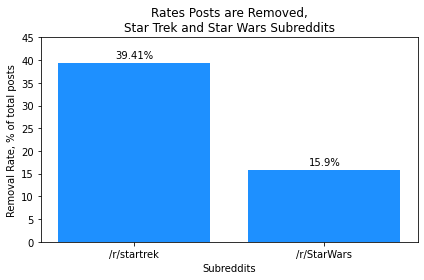

In [12]:
removal_rates = {
    'Star Trek': round((counts[0]/len(df[df["subreddit"] == "startrek"]))*100, 2),
    'Star Wars': round((counts[1]/len(df[df["subreddit"] == "starwars"]))*100, 2)
}
plt.title('Rates Posts are Removed,\nStar Trek and Star Wars Subreddits')
plt.xlabel('Subreddits')
plt.ylabel('Removal Rate, % of total posts')

plt.ylim(0, 45)
plt.bar(['/r/startrek', '/r/StarWars'], removal_rates.values(), color = 'dodgerblue')

plt.text(0, removal_rates['Star Trek']+1, str(removal_rates['Star Trek'])+'%', ha = 'center')
plt.text(1, removal_rates['Star Wars']+1, str(removal_rates['Star Wars'])+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/removal_rates.png');

In [13]:
#I referenced NLP 1 Lesson 5.01 to find the list of English stopwords
print(sorted((stopwords).words('english')))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

These are the words I'm removing from the stopwords list so I can see if they appear in the titles of removed posts: 'against', 'ain', 'am', 'and', 'are', 'aren', "aren't", 'be', 'been', 'being', 'but', 'can', 'couldn', 'did', 'didn', "didn't", 'do', 'does', 'doesn',"couldn't", "doesn't", 'doing', 'don', "don't", 'down', 'few', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having','he', 'her', 'hers', 'herself', 'him', 'himself', 'his','is', 'isn', "isn't", 'just',  'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'needn', "needn't", 'no', 'nor', 'not', 'off', 'on', 'only', 'or', 'out', 'over', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'should',  'so', 'some', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn', "wasn't", 'were', 'weren', "weren't", 'will', 'won', "won't", 'wouldn', "wouldn't",

I've kept all verbs in the titles (i.e. taken them out of the stopwords list). For example, I kept 'is' because I want to keep contractions like "isn't", which is not value neutral. While it seems more likely 'is' will appear in a value neutral statement, that seems to be tilting the playing field if I remove it.

I also opted to remove gendered pronouns from the stopwords list. I'm curious to see if there are any patterns to the use of gendered pronouns.

In [14]:
neutral_stopwords = ['a', 'about', 'above', 'after', 'again', 'all', 'an', 'any', 'as', 'at', 'because', 'before', 'below',
                     'between', 'both', 'by', 'd', 'during', 'each', 'for', 'from',  'here',  'how', 'i', 'if', 'in', 'into', 'it', "it's", 'its', 'itself',
                     'll', 'm', 'ma', 'me','my', 'myself', 'now', 'o', 'of', 'once', 'other', 'our', 'ours', 'ourselves', 
                     'own', 're', 's',   'such', 't', 'than', 'that', "that'll", 'the', 'their',
                     'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 
                      've', 'we', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
                     'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

I referenced the NLP Lab 5.02 on EDA for help with getting the following code right.

In [15]:
cvec = CountVectorizer(stop_words = neutral_stopwords)
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
vectorized.shape

(6946, 7908)

In [16]:
vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print(vectorized.shape)
type(vectorized)

(6946, 7908)


pandas.core.frame.DataFrame

In [17]:
#subreddit appears as a word, so I need to rename that column in order to be able to call it, below
df_copy = df.copy()
df_copy.rename(columns = {'subreddit': 'subreddit_name'}, inplace = True)

with_removed_vectorized = pd.concat([df['selftext'], df_copy['subreddit_name'], vectorized], axis = 1)
print(with_removed_vectorized.shape)
with_removed_vectorized.head()

(6946, 7910)


,selftext,subreddit_name,00,000,01,010,01x06,02,02png,03,...,ليلة,مهذبة,نسخ,وليلة,एक,लचस,षक,ดท,ทางเข,าส
0,[removed],startrek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[removed],startrek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[removed],startrek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[removed],startrek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[removed],startrek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))
print('='*20)

top_10_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed posts but not in the top 10 words for all posts {[word for word in top_10_removed if word not in top_10_all]}')
print('='*20)

top_25_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed posts but not in the top 25 words for all posts {[word for word in top_25_removed if word not in top_25_all]}')
print('='*20)

top_50_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed posts but not in the top 50 words for all posts {[word for word in top_50_removed if word not in top_50_all]}')


Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936
The following words appear in the top 10 most used words in removed posts but not in the top 10 words for all posts ['picard']
The following words appear in the top 25 most used words in removed posts but not in the top 25 words for all posts ['spoilers']
The following words appear in the top 50 most used words in removed posts but not in the top 50 words for all posts ['watch', 'enterprise', 'should', 'some', 'want', 'discovery']


In [19]:
print('Number of startrek posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["subreddit_name"] == "startrek"]))
print('Sanity check. Number of startrek posts from original dataframe:', len(df_copy[df_copy["subreddit_name"] == "startrek"]))
print('='*20)

top_10_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "startrek"\n posts but not in the top 10 words for all "startrek" posts {[word for word in top_10_removed_st if word not in top_10_all_st]}')
print('='*20)

top_25_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "startrek"\n posts but not in the top 25 words for all "startrek" posts {[word for word in top_25_removed_st if word not in top_25_all_st]}')
print('='*20)

top_50_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for all "startrek" posts {[word for word in top_50_removed_st if word not in top_50_all_st]}')


Number of startrek posts in new dataframe: 3537
Sanity check. Number of startrek posts from original dataframe: 3537
The following words appear in the top 10 most used words in removed "startrek"
 posts but not in the top 10 words for all "startrek" posts []
The following words appear in the top 25 most used words in removed "startrek"
 posts but not in the top 25 words for all "startrek" posts ['time', 'can']
The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for all "startrek" posts ['some', 'had', 'ever']


In [20]:
print('Number of StarWars posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["subreddit_name"] == "starwars"]))
print('Sanity check. Number of StarWars posts from original dataframe:', len(df_copy[df_copy["subreddit_name"] == "starwars"]))
print('='*20)

top_10_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "StarWars"\n posts but not in the top 10 words for all "StarWars" posts {[word for word in top_10_removed_sw if word not in top_10_all_sw]}')
print('='*20)

top_25_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "StarWars"\n posts but not in the top 25 words for all "StarWars" posts {[word for word in top_25_removed_sw if word not in top_25_all_sw]}')
print('='*20)

top_50_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for all "StarWars" posts {[word for word in top_50_removed_sw if word not in top_50_all_sw]}')


Number of StarWars posts in new dataframe: 3409
Sanity check. Number of StarWars posts from original dataframe: 3409
The following words appear in the top 10 most used words in removed "StarWars"
 posts but not in the top 10 words for all "StarWars" posts ['series', 'spoilers']
The following words appear in the top 25 most used words in removed "StarWars"
 posts but not in the top 25 words for all "StarWars" posts ['spoilers', 'should', 'show', 'finale', 'watch', 'but']
The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for all "StarWars" posts ['watch', 'order', 'question', 'reva', 'ep', 'want', 'best', 'season', 'sith', 'never', 'no']


In [21]:
print('Top 10, all posts:', top_10_all)
print('='*20)
print('Top 25, all posts:', top_25_all)
print('='*20)
print('Top 50, all posts:', top_50_all)

Top 10, all posts: ['star', 'and', 'is', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'on']
Top 25, all posts: ['star', 'and', 'is', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'on', 'was', 'episode', 'picard', 'vader', 'strange', 'worlds', 'have', 'do', 'be', 'like', 'series', 'so', 'are', 'season', 'snw']
Top 50, all posts: ['star', 'and', 'is', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'on', 'was', 'episode', 'picard', 'vader', 'strange', 'worlds', 'have', 'do', 'be', 'like', 'series', 'so', 'are', 'season', 'snw', 'did', 'would', 'just', 'one', 'or', 'spoilers', 'think', 'but', 'can', 'not', 'has', 'show', 'does', 'first', 'anyone', 'darth', 'more', 'question', 'time', 'finale', 'anakin', 'he', 'tng', 'best', 'see']


In [22]:
print('Top 10, all Star Trek posts:', top_10_all_st)
print('='*20)
print('Top 25, all Star Trek posts:', top_25_all_st)
print('='*20)
print('Top 50, all Star Trek posts:', top_50_all_st)

Top 10, all Star Trek posts: ['trek', 'star', 'and', 'is', 'new', 'picard', 'strange', 'worlds', 'on', 'snw']
Top 25, all Star Trek posts: ['trek', 'star', 'and', 'is', 'new', 'picard', 'strange', 'worlds', 'on', 'snw', 'episode', 'season', 'was', 'tng', 'be', 'enterprise', 'have', 'are', 'so', 'do', 'series', 'discovery', 'just', 'has', 'would']
Top 50, all Star Trek posts: ['trek', 'star', 'and', 'is', 'new', 'picard', 'strange', 'worlds', 'on', 'snw', 'episode', 'season', 'was', 'tng', 'be', 'enterprise', 'have', 'are', 'so', 'do', 'series', 'discovery', 'just', 'has', 'would', 'did', 'time', 'or', 'can', 'first', 'like', 'spoilers', 'one', 'ds9', 'question', 'not', 'best', 'does', 'think', 'tos', 'but', 'more', 'voyager', 'anyone', 'spock', 'watch', 'borg', 'paramount', 'show', 'love']


In [23]:
print('Top 10, all Star Wars posts:', top_10_all_sw)
print('='*20)
print('Top 25, all Star Wars posts:', top_25_all_sw)
print('='*20)
print('Top 50, all Star Wars posts:', top_50_all_sw)

Top 10, all Star Wars posts: ['obi', 'kenobi', 'wan', 'and', 'wars', 'is', 'star', 'vader', 'was', 'on']
Top 25, all Star Wars posts: ['obi', 'kenobi', 'wan', 'and', 'wars', 'is', 'star', 'vader', 'was', 'on', 'like', 'have', 'episode', 'darth', 'do', 'series', 'anakin', 'did', 'one', 'would', 'be', 'so', 'are', 'just', 'or']
Top 50, all Star Wars posts: ['obi', 'kenobi', 'wan', 'and', 'wars', 'is', 'star', 'vader', 'was', 'on', 'like', 'have', 'episode', 'darth', 'do', 'series', 'anakin', 'did', 'one', 'would', 'be', 'so', 'are', 'just', 'or', 'jedi', 'but', 'finale', 'think', 'new', 'he', 'spoilers', 'show', 'not', 'can', 'anyone', 'disney', 'made', 'does', 'more', 'his', 'know', 'see', 'scene', 'out', 'some', 'clone', 'should', 'really', 'first']


-----

# Comparing Blank Submissions Across the Subreddits

Does either subreddit have a higher rate of blank submissions? For the purposes of this I'm removing the 'removed' and 'deleted' posts.

In [24]:
df['subreddit'].value_counts()

startrek    3537
starwars    3409
Name: subreddit, dtype: int64

In [25]:
df[df['selftext'] == '']['subreddit'].value_counts()

starwars    1729
startrek     630
Name: subreddit, dtype: int64

In [26]:
blank_values = df[df['selftext'] == '']['subreddit'].value_counts().tolist()
blank_keys = df[df['selftext'] == '']['subreddit'].value_counts().keys().tolist()
blank_keys

['starwars', 'startrek']

In [27]:
sw_percent_blank = blank_values[0]/len(df[df['subreddit'] == 'starwars'])*100
st_percent_blank = blank_values[1]/len(df[df['subreddit'] == 'startrek'])*100
print('Star Wars percent blank submissions:', sw_percent_blank)
print('='*20)
print('Star Trek percent blank submissions:', st_percent_blank)

Star Wars percent blank submissions: 50.71868583162218
Star Trek percent blank submissions: 17.8117048346056


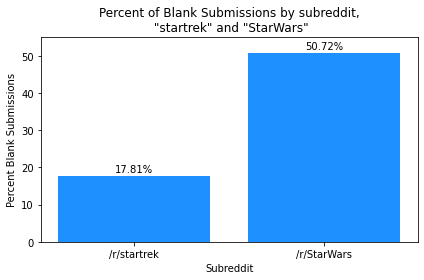

In [28]:
plt.title('Percent of Blank Submissions by subreddit,\n "startrek" and "StarWars"')
plt.xlabel('Subreddit')
plt.ylabel('Percent Blank Submissions')
plt.ylim(0,55)
plt.bar(['/r/startrek', '/r/StarWars'], [st_percent_blank, sw_percent_blank], color = 'dodgerblue')

plt.text(1, sw_percent_blank+1, str(round(sw_percent_blank, 2))+'%', ha = 'center')
plt.text(0, st_percent_blank+1, str(round(st_percent_blank, 2))+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/percent_blank_posts.png');


Because of the high percentage of blank posts, consisting just of a title, in the StarWars subreddit, I'm going to include the titles in my model building. It seems to be an important part of how StarWars subredditors communicate with each other.

# Exploring Post Length and Number of Words In Non-Removed or Deleted Submission Posts

There are a lot of blank submissions. There are 6 '[deleted]' submissions, as well. '[deleted]' means that [the user deleted the post](https://www.reddit.com/r/help/comments/h92oqg/what_does_deleted_mean/).

For the purposes of examining word counts in these submissions, I've removed the empty and '[deleted]' submissions.

In [29]:
#I have to go back and look at '[deleted]'
no_remov_del_subm = df[(df['selftext'] != '[removed]') & (df['selftext'] != '[deleted]')]
print(no_remov_del_subm['selftext'].value_counts()[:5])
print(no_remov_del_subm.shape)
no_remov_del_subm.head(2)

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0,0,72,12


In preparation for vectorizing I changed the 'subreddit' column name to 'subreddit_name'.

In [30]:
no_remov_del_subm = no_remov_del_subm.rename(columns = {'subreddit': 'subreddit_name'})
no_remov_del_subm.head(1)

,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22


In [31]:
print(f'Submission length (characters) mean by subreddit is {no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].mean()}')
print(f'Submission length (characters median by subreddit is {no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].median()}')

Submission length (characters) mean by subreddit is subreddit_name
startrek    459.099486
starwars    243.629190
Name: submission_length, dtype: float64
Submission length (characters median by subreddit is subreddit_name
startrek    185.0
starwars      0.0
Name: submission_length, dtype: float64


I referred to the [matplotplib documentation](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html) to create the below subplot. Very helpful. [This post](https://stackoverflow.com/a/15858264) helped me see how to adjust the ylim for subplots. [This documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html) showed me how to shift the title up a little so it wouldn't be so close to the subplot labels.

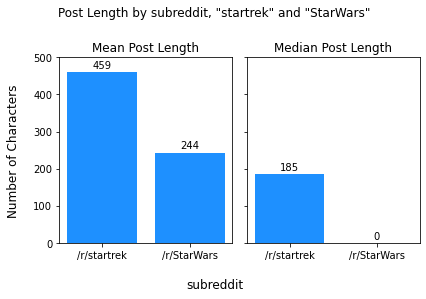

In [32]:
subm_mean_len = no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].mean().tolist()
subm_median_len = no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Length by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_mean_len[0], subm_mean_len[1]], color = 'dodgerblue')
ax1.set_title('Mean Post Length')
ax1.set_ylim(0,500)
ax1.text(0, subm_mean_len[0]+10, round(subm_mean_len[0]), ha = 'center')
ax1.text(1, subm_mean_len[1]+10, round(subm_mean_len[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_median_len[0], subm_median_len[1]], color = 'dodgerblue')
ax2.set_title('Median Post Length')
ax2.text(0, subm_median_len[0]+10, round(subm_median_len[0]), ha = 'center')
ax2.text(1, subm_median_len[1]+10, round(subm_median_len[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_length.png');

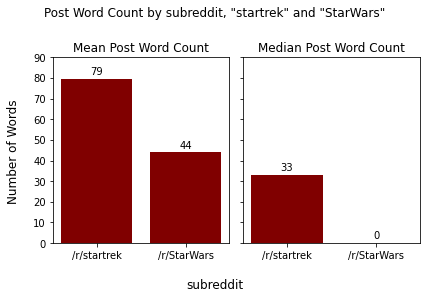

In [33]:
subm_word_count_mean = no_remov_del_subm.groupby(["subreddit_name"])["submission_word_count"].mean().tolist()
subm_word_count_median = no_remov_del_subm.groupby(["subreddit_name"])["submission_word_count"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Word Count by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Words')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_mean[0], subm_word_count_mean[1]], color = 'maroon')
ax1.set_title('Mean Post Word Count')
ax1.set_ylim(0,90)
ax1.text(0, subm_word_count_mean[0]+2, round(subm_word_count_mean[0]), ha = 'center')
ax1.text(1, subm_word_count_mean[1]+2, round(subm_word_count_mean[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_median[0], subm_word_count_median[1]], color = 'maroon')
ax2.set_title('Median Post Word Count')
ax2.text(0, subm_word_count_median[0]+2, round(subm_word_count_median[0]), ha = 'center')
ax2.text(1, subm_word_count_median[1]+2, round(subm_word_count_median[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_word_count.png');

-----

# Exploring Word Length in Posts

I may be able to determine a precise word length average once I've vectorized, though I suspect that will take a really long time to do (and may not happen as a result.) The x factor is how many blank spaces there are in a given post. My rough approach assumes one blank space per word, which is a rough estimate because that's not necessarily true. But it gives us a relatively quick estimate of word length.

In [34]:
only_text = no_remov_del_subm[no_remov_del_subm['selftext'] != '']
only_text['rough_avg_word_length'] = (only_text['submission_length']-only_text['submission_word_count'])/only_text['submission_word_count']
only_text.head()

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_34226/3405056248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_text['rough_avg_word_length'] = (only_text['submission_length']-only_text['submission_word_count'])/only_text['submission_word_count']


,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count,rough_avg_word_length
2026,1656257863,Now that I’ve moved to a bigger place the time has come to display the Enterprise and her crew! I’m so happy with how it looks! Engage!\n\n[images of bridge](https://imgur.com/a/yRZaV0f),startrek,Had the TNG Bridge Playset packed away for too long!,184,30,52,10,5.133333
2027,1656255805,Is that just a fun nod for people paying attention or was Benny meant to be a real person and not just in Sisko's mind?,startrek,Benny Russell wrote M'Benga's book?,119,25,35,5,3.760000
2028,1656255728,Just wondering where you can stream the new Star Trek shows in Canada? I know Paramount plus has the the old ones.,startrek,Streaming the new Star term shows?,114,22,34,6,4.181818
2029,1656254381,"Just interested in hearing some cool ideas. I’d love to see the OG crew take on the Borg but I’m curious how it could differentiate itself from the other recent takes on them that we’ve seen.\n\nI’m also curious as to whether or not the crew is still on their five-year mission, and what justification would be used to bring them back into space. Do we get retired Admiral Kirk? Sulu on the Excel...",startrek,What are your pitches for Star Trek Kelvin 4?,487,90,45,9,4.411111
2030,1656253203,I was watching the new episode of SNW and it just hit me that Ortagus wears red rather than gold. And I was wondering if anyone knew why?,startrek,Why Does Ortagus Wear Red? SNW,137,28,30,6,3.892857


In [35]:
only_text.groupby('subreddit_name')['rough_avg_word_length'].mean()

subreddit_name
startrek    5.441365
starwars    4.821179
Name: rough_avg_word_length, dtype: float64

In [36]:
only_text.groupby('subreddit_name')['rough_avg_word_length'].median()

subreddit_name
startrek    4.563636
starwars    4.418605
Name: rough_avg_word_length, dtype: float64

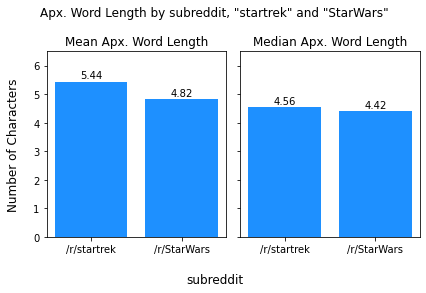

In [37]:
mean_word_length = only_text.groupby('subreddit_name')['rough_avg_word_length'].mean().tolist()
median_word_length = only_text.groupby('subreddit_name')['rough_avg_word_length'].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Apx. Word Length by subreddit, "startrek" and "StarWars"')
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [mean_word_length[0], mean_word_length[1]], color = 'dodgerblue')
ax1.set_title('Mean Apx. Word Length')
ax1.set_ylim(0,6.5)
ax1.text(0, mean_word_length[0]+.1, round(mean_word_length[0], 2), ha = 'center')
ax1.text(1, mean_word_length[1]+.1, round(mean_word_length[1], 2), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [median_word_length[0], median_word_length[1]], color = 'dodgerblue')
ax2.set_title('Median Apx. Word Length')
ax2.text(0, median_word_length[0]+.1, round(median_word_length[0], 2), ha = 'center')
ax2.text(1, median_word_length[1]+.1, round(median_word_length[1], 2), ha = 'center')

plt.tight_layout()
plt.savefig('images/word_lengths.png');

-----

# Exploring most Common Words in Submissions (Posts) and Titles
Because so much communication on the Star Wars subreddit occurs in titles, I've combined the two and analyzed the frequency of words.

Initially, I tried this with the 'neutral' stopwords, but there are too many of the other stop words appearing, so I've eliminated all English stopwords.

In [38]:
no_remov_del_subm.head()

,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0,0,72,12
1396,1656224204,,startrek,Analysis: Star Trek: The Next Generation’ Guest Stars Most Likely To Appear In ‘Picard’ Season 3,0,0,96,16
1397,1656207850,,startrek,"One of the first occasions in which the word ""hell"" was used as profanity on television.",0,0,88,16
1398,1656195635,,startrek,Is A TOS Reboot Coming Soon?,0,0,28,6


In [39]:
all_blanks_and_text = no_remov_del_subm.copy()
all_blanks_and_text['all_words']= no_remov_del_subm['selftext']+' '+ no_remov_del_subm['title']
all_blanks_and_text = all_blanks_and_text[['subreddit_name', 'all_words']]
all_blanks_and_text.head()

,subreddit_name,all_words
1394,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.
1395,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism."
1396,startrek,Analysis: Star Trek: The Next Generation’ Guest Stars Most Likely To Appear In ‘Picard’ Season 3
1397,startrek,"One of the first occasions in which the word ""hell"" was used as profanity on television."
1398,startrek,Is A TOS Reboot Coming Soon?


In [40]:
print(all_blanks_and_text.shape)

(5005, 2)


In [54]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(all_blanks_and_text['all_words'])
vectorized = cvec.transform(all_blanks_and_text['all_words'])
vectorized.shape

(5005, 17719)

In [55]:
vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print(vectorized.shape)
type(vectorized)

(5005, 17719)


pandas.core.frame.DataFrame

In [56]:
vectorized.head()

,00,000,001,006225_8c6a1dd3,01,010,01414tqwn0t0,01x06,02,021,...,ليلة,مهذبة,نسخ,وليلة,एक,लचस,षक,ดท,ทางเข,าส
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Initially, I was getting too many rows. Reading [this](https://stackoverflow.com/a/55726005) made it clear it was because of residual indexes, so I reset the indexes. Initially, I got some weird additional columns, so I played with it


In [57]:
subreddit_names = pd.DataFrame()
subreddit_names['subreddit_name'] = all_blanks_and_text['subreddit_name']
subreddit_names = subreddit_names.reset_index()

all_words_df = pd.concat([subreddit_names, vectorized], axis = 1)
all_words_df = all_words_df.drop(columns = 'index')
print(all_words_df.shape)
all_words_df.head()

(5005, 17719)


,subreddit_name,00,000,001,006225_8c6a1dd3,01,010,01414tqwn0t0,01x06,02,...,ليلة,مهذبة,نسخ,وليلة,एक,लचस,षक,ดท,ทางเข,าส
0,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
print(f'The top 10 words in all these posts are:\n{all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Trek posts are:\n{all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Wars posts are:\n{all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')


The top 10 words in all these posts are:
star       2390
like       1670
trek       1665
just       1605
episode    1582
obi        1211
wan        1156
vader      1138
wars       1127
season     1107
dtype: int64
The top 10 words in all Star Trek posts are:
trek       1660
star       1453
picard     1009
like        867
just        858
new         780
episode     732
season      559
time        532
know        422
dtype: int64
The top 10 words in all Star Wars posts are:
obi        1210
wan        1155
vader      1135
wars       1068
star        937
kenobi      855
episode     850
like        803
just        747
anakin      585
dtype: int64


**THIS IS WHERE I LEFT OFF ON 6/26/22**

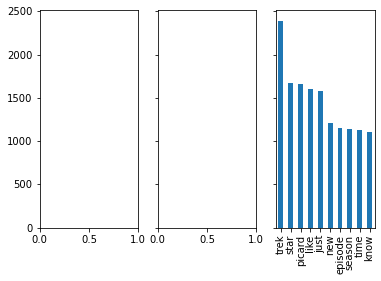

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1 = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(10).plot(kind = 'bar')
ax2 = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(10).plot(kind = 'bar')
#ax3 = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(10).plot(kind = 'bar')


-----

# Exploring Word Counts in Non-Removed Submission Posts with Proper Names Removed

In [187]:
#I have to go back and look at '[deleted]'
only_filled_subm = df[(df['selftext'] != '[removed]') & (df['selftext'] != '') & (df['selftext'] != '[deleted]')]
print(only_filled_subm['selftext'].value_counts()[:5])
print(only_filled_subm.shape)
only_filled_subm.head()

So I just started watching Strange New Worlds? Is it me or is the Captains Quarters HUGE on this show? When we saw Picard’s quarters in TNG it was never this large. How is it as the ships of the Federation get more advanced they seem to get more utilitarian? What are peoples thought?                                                                                                                           1
&amp;#x200B;\n\n[\\"You were my brother Anakin, I STILL love you.\\"](https://preview.redd.it/osxeed2auh791.png?width=1517&amp;format=png&amp;auto=webp&amp;s=5ceea1e0204b7390278c22a509966b2ec8ef351f)                                                                                                                                                                                                                1
When Darth Vader and Obi-Wan are fighting in the final episode, just right after Vader used the force to open a hole in the ground to cover Obi-Wan with stones, I was expecting him t

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
2063,1656180319,So I just started watching Strange New Worlds? Is it me or is the Captains Quarters HUGE on this show? When we saw Picard’s quarters in TNG it was never this large. How is it as the ships of the Federation get more advanced they seem to get more utilitarian? What are peoples thought?,startrek,HUGE Captains Quarters?!?,284,54,25,3
2064,1656175057,"One of the things I always thought was nice about star trek, is how positive it was, in an era of apocalyptic and all around bad world view that was common with syfy shows/movies, we had got a world where the entire planet was at peace. cause we got over all of our problems.I've heard that some just write it off as liberal nonsense or whatever, but I just thought it was...nice.",startrek,a more positive science fiction series,380,72,38,6
2065,1656171780,"I am trying to translate the moive of PC game Star Trek: Klingon Academy. There is a creature appear Several times. It is called something like ""corling"" or ""Korling"" by klingon. I'm not sure what it is because there are no subtitles. I didn't find any resemble noun in memory alpha or beta. Can anyone tell me anything about it? Even an exact name will do. Context is a toothless korling or a st...",startrek,"Looking for a creature from star trek game, might be a klingon creature.",442,81,72,13
2066,1656168467,The image is at 0:58 in the video.,startrek,A shot of the Gorn in the trailer???,34,8,36,8
2067,1656166315,"lol WTF!? This bizarre line from Kirk just came out of nowhere with no evidence or previously seen footage to back it up, at the beginning of ""Wolf in the Fold"".\n\nWhy?!",startrek,"""Scotty's resentment towards women""",168,32,35,4


-----

# Exploring Word Counts in Combined Submission and Title, Non-Removed Posts

In [180]:
no_removed = df[df['selftext'] != '[removed]']
print(no_removed['selftext'].value_counts()[:5])
print(no_removed.shape)
no_removed.head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     2396
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
1408,1656165357,,startrek,Does 'Star Trek: Strange New Worlds' attain warp speed? : Pop Culture Happy Hour,0,0,80,14
1409,1656113264,,startrek,Preview: Strange New Worlds 1x09,0,0,32,5
1410,1656092693,,startrek,John de Lancie Talks About His Experience Returning As Q In ‘Star Trek: Picard’ Season 2,0,0,88,16
1411,1656085029,,startrek,"‘KHAAAAN!’: why Wrath of Khan remains the greatest Star Trek movie, 40 years on",0,0,79,14
1412,1656071838,,startrek,"‘KHAAAAN!’: why Wrath of Khan remains the greatest Star Trek movie, 40 years on",0,0,79,14


-----

# Exploring Word Counts in Submission and Titles, Non-removed Posts, with Proper Names Removed

**note to self: make visualizations of these word counts. See NLP lab for guidance**